In [262]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, precision_score, accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_validate
%matplotlib inline

In [263]:
### Mes fonctions ###

# Crée une colonne indiquant si la personne a des études en adéquation avec son département
from sklearn.metrics import precision_recall_curve


def definir_match_etudes_poste(row):
    """
    Retourne 1 si les études correspondent au département, 0 sinon.
    """
    etudes = row['domaine_etude']
    dept = row['departement']
    
    # 1. Dictionnaire de correspondance (Etudes -> Départements acceptables)
    mapping_logique = {
        # Les Techs vont au Consulting
        'Infra & Cloud': ['Consulting'],
        'Transformation Digitale': ['Consulting'],
        
        # Les Business vont au Commercial
        'Marketing': ['Commercial'],
        'Entrepreunariat': ['Commercial'],
        
        # Les RH vont aux RH
        'Ressources Humaines': ['Ressources Humaines']
    }
    
    # 2. Gestion du cas "Autre" ( On considère que c'est pas OK)
    if etudes == 'Autre':
        return 0

    # 3. Vérification standard
    # On regarde si le département actuel est dans la liste autorisée pour ces études
    if etudes in mapping_logique:
        if dept in mapping_logique[etudes]:
            return 1 # C'est un Match
        else:
            return 0 # C'est un Mismatch (ex: Marketing -> Consulting)
            
    # Sécurité pour les cas imprévus
    return 0

def plot_f1_vs_threshold(estimator, X, y):
    """
    Affiche la courbe F1-Score vs Seuil pour un estimateur donné.
    """
    # 1. Récupérer les probabilités
    # Vérifie si l'estimateur a predict_proba, sinon decision_function
    if hasattr(estimator, "predict_proba"):
        probas = estimator.predict_proba(X)[:, 1]
    else:
        probas = estimator.decision_function(X)
        
    # 2. Calculer P, R et Thresholds
    precision, recall, thresholds = precision_recall_curve(y, probas)
    
    # 3. Calculer F1 pour chaque seuil (f1 = 2*P*R / (P+R))
    numerator = 2 * recall * precision
    denominator = recall + precision
    
    # Gestion de la division par zéro
    f1_scores = np.divide(numerator, denominator, out=np.zeros_like(denominator), where=denominator!=0)
    
    # On enlève la dernière valeur de P et R car thresholds est plus court de 1
    f1_scores = f1_scores[:-1] 
    
    # 4. Trouver l'optimum
    best_idx = np.argmax(f1_scores)
    best_thresh = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    
    # 5. Graphique
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores, label='F1 Score', color='#2196F3', lw=2)
    plt.plot(thresholds, precision[:-1], label='Précision', color='green', ls='--', alpha=0.4)
    plt.plot(thresholds, recall[:-1], label='Rappel', color='red', ls='--', alpha=0.4)
    
    # Marqueur de l'optimum
    plt.axvline(best_thresh, color='black', ls=':', label=f'Seuil optimal: {best_thresh:.2f}')
    plt.scatter(best_thresh, best_f1, c='black', zorder=10)
    plt.text(best_thresh+0.02, best_f1, f'F1={best_f1:.2f}', va='center')
    
    plt.title(f"Évolution du F1-Score selon le Seuil (Max: {best_f1:.2f})")
    plt.xlabel("Seuil de décision")
    plt.ylabel("Score")
    plt.legend(loc="lower center")
    plt.grid(True, alpha=0.3)
    plt.show()
    return best_thresh

In [264]:
from sklearn.base import BaseEstimator, TransformerMixin

class SalaryFeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self, group_cols=['poste', 'niveau_education'], 
                 target_col='revenu_mensuel', 
                 drop_original=True,
                 drop_reference=True,
                 threshold_std=1.0): 
        
        self.group_cols = group_cols
        self.target_col = target_col
        self.drop_original = drop_original
        self.drop_reference = drop_reference
        self.threshold_std = threshold_std
        
        self.group_stats_ = None
        self.global_stats_ = {}
        self.feature_names_in_ = None

    def fit(self, X, y=None):
        X = X.copy()
        if hasattr(X, 'columns'):
            self.feature_names_in_ = list(X.columns)
        else:
            self.feature_names_in_ = [f"x{i}" for i in range(X.shape[1])]

        # 1. Stats globales
        self.global_stats_['mean'] = X[self.target_col].mean()
        self.global_stats_['std'] = X[self.target_col].std()
        self.global_stats_['median'] = X[self.target_col].median()

        # 2. Stats par groupe
        self.group_stats_ = X.groupby(self.group_cols)[self.target_col].agg(['mean', 'std', 'median'])
        self.group_stats_['std'] = self.group_stats_['std'].fillna(1.0).replace(0, 1.0)
        
        return self

    def transform(self, X):
        X = X.copy()
        
        # # 1. Join
        # X = X.join(self.group_stats_, on=self.group_cols)

        X = pd.merge(
            X, 
            self.group_stats_, 
            left_on=self.group_cols, 
            right_index=True, 
            how='left'
        )
        
        # 2. Remplissage
        X['mean'] = X['mean'].fillna(self.global_stats_['mean'])
        X['std'] = X['std'].fillna(self.global_stats_['std'])
        X['median'] = X['median'].fillna(self.global_stats_['median'])
        
        X['salaire_median_ref'] = X['median']
        
        # 3. Calcul Z-Score
        X['z_score_salaire'] = (X[self.target_col] - X['mean']) / X['std']
        
        # 4. Discrétisation
        X['score_competitivite'] = 0
        X.loc[X['z_score_salaire'] < -self.threshold_std, 'score_competitivite'] = -1
        X.loc[X['z_score_salaire'] > self.threshold_std, 'score_competitivite'] = 1
        
        # 5. NETTOYAGE
        cols_to_drop = ['mean', 'std', 'median', 'z_score_salaire']
        
        if self.drop_original:
            cols_to_drop.append(self.target_col)
        if self.drop_reference:
            cols_to_drop.append('salaire_median_ref')
            
        # --- C'EST ICI QUE VOUS FAITES VOTRE BRICOLAGE PROPREMENT ---
        # On supprime TOUJOURS 'niveau_education' car on a décidé qu'il était inutile
        if 'niveau_education' in X.columns:
            cols_to_drop.append('niveau_education')
            
        # Par contre, ON NE TOUCHE PAS à 'poste', on le laisse passer !
            
        X = X.drop(columns=cols_to_drop, errors='ignore')
            
        return X

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        feature_names = list(input_features)
        
        # 1. Suppression target
        if self.drop_original and self.target_col in feature_names:
            feature_names.remove(self.target_col)
            
        # 2. Suppression explicite de niveau_education (SYNCHRONISATION !)
        if 'niveau_education' in feature_names:
            feature_names.remove('niveau_education')

        # 3. Suppression médiane (si demandé)
        if not self.drop_reference:
            feature_names.append('salaire_median_ref')
            
        # 4. Ajout du score
        feature_names.append('score_competitivite')
        
        return np.array(feature_names, dtype=object)

In [265]:

df_eval = pd.read_csv("./extrait_eval.csv")
df_sirh = pd.read_csv("./extrait_sirh.csv")
df_sondage = pd.read_csv("./extrait_sondage.csv")

In [266]:
# Exploration des données

# on converti la colonne df["eval_number"] en nombre, voir si on peut faire un rapprochement
# avec l'id et le numéro de sondage => OUI c'est le cas


df_eval['eval_number'] = df_eval['eval_number'].str.lower().str.replace('e_', '').astype(int)

In [267]:
# Logiquement l'id = le numero d'éval et de sondage
# donc on va faire la jointure là-dessus
# On drop à chaque fois la colonne de droite car la jointure garde les deux colonnes left et right
# sur lesquelles on fait la jointure
df_final = (
    df_eval
    .merge(df_sirh, left_on='eval_number', right_on='id_employee')  # Jointure 1
    .drop(columns=['id_employee'])                     # Nettoyage 1
    .merge(df_sondage, left_on='eval_number', right_on='code_sondage')   # Jointure 2 (on réutilise 'id' qui vient de df1)
    .drop(columns=['code_sondage'])                      # Nettoyage 2
)

In [268]:
# ont uniquement la valeur 1, partout donc on enlève
df_clean = df_final.drop(columns=["nombre_employee_sous_responsabilite","ayant_enfants"])
# n'a que la valeur 80 donc on enlève également
df_clean = df_clean.drop(columns="nombre_heures_travailless")
# on enlève également les id
df_clean = df_clean.drop(columns="eval_number")

In [ ]:
###################################
#       FEATURE ENGINEERING       #
###################################


# Calcul du ratio année depuis la dernière promotion / années dans l'entreprise
# si =0 alors c'est plutot positif, plus on s'approche de 1 plus c'est négatif
# les nouveaux arrivés ont 0 années dans l'entreprise et on met le ratio à 0

df_clean['Ratio_Stagnation_entreprise'] = np.where(
    df_clean['annees_dans_l_entreprise'] == 0, 
    0, 
    df_clean['annees_depuis_la_derniere_promotion'] / df_clean['annees_dans_l_entreprise']
)

# Application de la fonction pour créer la nouvelle colonne
df_clean['match_etudes_poste'] = df_clean.apply(definir_match_etudes_poste, axis=1)

df_clean['duree_moyenne_par_poste'] = df_clean['annee_experience_totale'] / (df_clean['nombre_experiences_precedentes'] + 1)

# Indicateur binaire si habite loin (plus de grosse_distance km)
grosse_distance = 17
df_clean['habite_loin'] = (df_clean['distance_domicile_travail'] > grosse_distance).astype(int)

# Ratio années dans le poste actuel / années dans l'entreprise
df_clean['ratio_stagnation_poste'] = df_clean['annees_dans_le_poste_actuel'] / (df_clean['annees_dans_l_entreprise'] + 1)

# vrai si nouveau responsable (moins de 2 ans sous ce responsable)
df_clean['nouveau_responsable'] = (df_clean['annes_sous_responsable_actuel'] < 2).astype(int)



In [270]:
# On supprime les colonnes qui seraient trop redondante suite au data engineering
df_clean = df_clean.drop(columns=['domaine_etude',
                                'annees_depuis_la_derniere_promotion',
                                'nombre_experiences_precedentes',
                                'annees_dans_l_entreprise',
                                'annees_dans_le_poste_actuel',
                                'distance_domicile_travail',
                                'annes_sous_responsable_actuel'])

In [271]:
# on supprime les colonnes trop corrélées d'après le profiling généré auparavant
df_clean = df_clean.drop(columns=['age', 'departement', 'note_evaluation_actuelle','niveau_hierarchique_poste'])

In [272]:
# Test de supression de lignes au vue des permutation values
df_clean = df_clean.drop(columns=['annee_experience_totale'])

In [273]:
# On transforme Oui et Non en 0 et 1 ; Pareil pour le genre
from ydata_profiling import ProfileReport


df_clean['a_quitte_l_entreprise'] = df_clean['a_quitte_l_entreprise'].map({'Oui': 1, 'Non': 0})
df_clean['heure_supplementaires'] = df_clean['heure_supplementaires'].map({'Oui': 1, 'Non': 0})
df_clean['genre'] = df_clean['genre'].map({'M': 0, 'F': 1})
# Vérification pour être sur
# print("Valeurs uniques dans la target :", df_clean['a_quitte_l_entreprise'].unique())

# On corrige des strings qui sont en fait des nombres
# en fait non bizarrement sur cet ordi c'est déjà transformé...
df_clean['augementation_salaire_precedente'] = df_clean['augementation_salaire_precedente'].str.replace('%', '').astype(int)


# Petites colonnes avec peux de possibilités qu'on one-hot encode
# df_clean = pd.get_dummies(
#     df_clean, 
#     #columns=['frequence_deplacement','poste','departement','statut_marital'],
#     columns=['frequence_deplacement','poste','statut_marital'], 
#     drop_first=True,   # Pour éviter la redondance (ex: si ce n'est ni Occasionnel ni Fréquent, c'est forcément Aucun)
#     dtype=int          # Pour avoir des 0 et 1 (au lieu de True/False)
# )

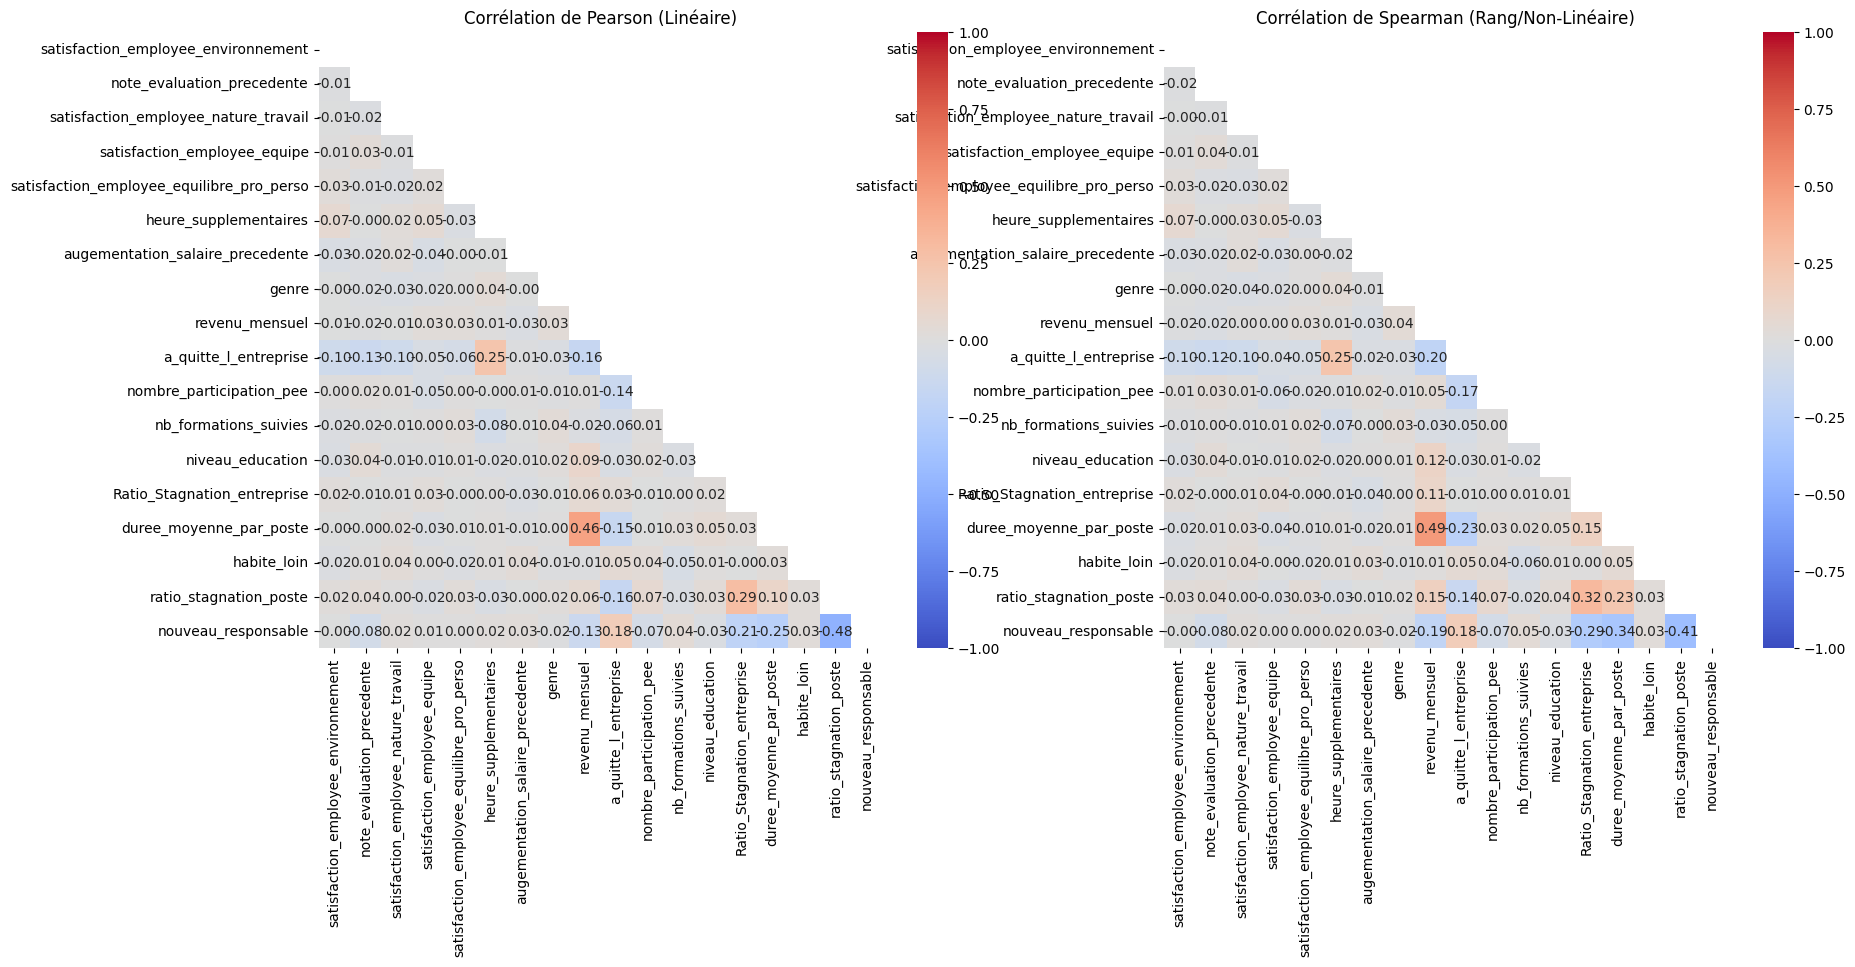

In [274]:
### Suppression des Collinéarités ###

# 1. Sélectionner seulement les colonnes numériques de votre X_train
# (Excluez les colonnes catégorielles pour l'instant)
df_num = df_clean.select_dtypes(include=['number'])

# 2. Calculer les matrices
corr_pearson = df_num.corr(method='pearson')
corr_spearman = df_num.corr(method='spearman')

# 3. Affichage (On masque la moitié haute car c'est symétrique)
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

mask = np.triu(np.ones_like(corr_pearson, dtype=bool))

sns.heatmap(corr_pearson, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, ax=ax[0])
ax[0].set_title("Corrélation de Pearson (Linéaire)")

sns.heatmap(corr_spearman, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, ax=ax[1])
ax[1].set_title("Corrélation de Spearman (Rang/Non-Linéaire)")

plt.show()

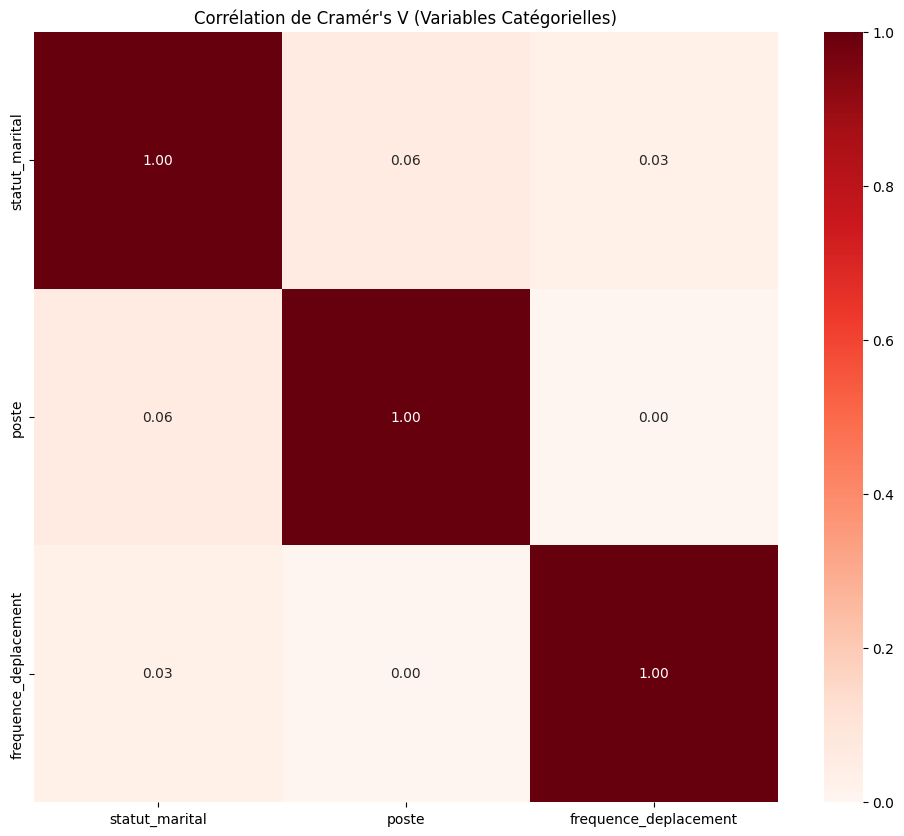

In [275]:
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Fonction pour calculer le V de Cramér entre deux séries
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# 2. Sélectionner vos variables catégorielles
# (Adaptez la liste si besoin)
cat_cols = df_clean.select_dtypes(include=['object', 'category']).columns.tolist()

# 3. Calculer la matrice
rows = []
for var1 in cat_cols:
    col = []
    for var2 in cat_cols:
        cramers = cramers_v(df_clean[var1], df_clean[var2])
        col.append(cramers)
    rows.append(col)

cramers_results = pd.DataFrame(rows, columns=cat_cols, index=cat_cols)

# 4. Afficher la Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cramers_results, annot=True, fmt='.2f', cmap='Reds', vmin=0, vmax=1)
plt.title("Corrélation de Cramér's V (Variables Catégorielles)")
plt.show()

In [276]:

# profile = ProfileReport(df_clean, title="Rapport d'Exploration du data frame final")
# profile.to_file("rapport_final.html")

In [277]:
# 1. Préparation du train test
from sklearn.preprocessing import KBinsDiscretizer


X = df_clean.drop(columns=['a_quitte_l_entreprise'])
y = df_clean['a_quitte_l_entreprise']

# 2. Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



# 1. Définir vos variables (comme dans votre capture d'écran)
# Note : On inclut 'poste' et 'niveau_education' ici si on veut les encoder pour le modèle
# MAIS votre SalaryFeatureEngineering en a besoin avant l'encodage "brut".
cols_a_encoder = ['frequence_deplacement', 'statut_marital', 'poste']

# 2. Créer l'étape d'encodage (Le remplaçant de get_dummies)
# handle_unknown='ignore' évite les crashs si une nouvelle catégorie apparait
encodage = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(drop='first', handle_unknown='ignore'), cols_a_encoder),
        # La discrétisation pour le ratio (Binning)
        # strategy='quantile' crée des groupes de taille égale (recommandé pour votre cas)
        # n_bins=5 crée 5 niveaux (Très faible, Faible, Moyen, Élevé, Très élevé)
        ('binning_ratio', KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile', quantile_method='averaged_inverted_cdf'),
          ['ratio_stagnation_poste'])
    ],
    remainder='passthrough', # IMPORTANT : Garde les autres colonnes (numériques) telles quelles
    verbose_feature_names_out=False # pour éviter d'avoir "remainder_" devant le nom de nos colonnes
)

# 3. Modèle
rf_model = RandomForestClassifier(random_state=42)
# class_weight='balanced' pour forcer la Forêt à donner plus d'importance aux employés 
# qui partent (la classe minoritaire).

# Création du pipeline complet
pipeline = ImbPipeline([
    # Avant de one-hot encoder les colonnes catégorielles
    ('salary_ref', SalaryFeatureEngineering(
        group_cols=['poste', 'niveau_education'],
        target_col='revenu_mensuel',
        drop_original=True,  # On supprime la colonne salaire_mensuel originale car corrélée
        drop_reference=True, # On ne garde pas la colonne de référence médiane
        threshold_std=1      # Seuil pour la discrétisation
    )),
    
    # one-hot encoding
    ('encoder', encodage),
    
    ('smote', SMOTE(random_state=42)), # Création des synthétiques pour équilibrer les classes

    # notre modèle
    ('model', rf_model) 
])


In [278]:
### les autres pipelines pour le dummy et me la régression logistique ###

### dummy ###

from sklearn.discriminant_analysis import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression


pipeline_dummy = ImbPipeline([
    # Avant de one-hot encoder les colonnes catégorielles
    ('salary_ref', SalaryFeatureEngineering(
        group_cols=['poste', 'niveau_education'],
        target_col='revenu_mensuel',
        drop_original=True,  # On supprime la colonne salaire_mensuel originale car corrélée
        drop_reference=True, # On ne garde pas la colonne de référence médiane
        threshold_std=1      # Seuil pour la discrétisation
    )),
    
    # one-hot encoding
    ('encoder', encodage),
    
    # pas besoin de smote pour le dummy

    # notre modèle
    ('model', DummyClassifier(strategy='stratified', random_state=42)) 
])

pipeline_logreg = ImbPipeline([
    # Avant de one-hot encoder les colonnes catégorielles
    ('salary_ref', SalaryFeatureEngineering(
        group_cols=['poste', 'niveau_education'],
        target_col='revenu_mensuel',
        drop_original=True,  # On supprime la colonne salaire_mensuel originale car corrélée
        drop_reference=True, # On ne garde pas la colonne de référence médiane
        threshold_std=1      # Seuil pour la discrétisation
    )),
    
    # one-hot encoding
    ('encoder', encodage),
    
    ('scaler', StandardScaler()), # Normalisation pour la régression logistique

    ('smote', SMOTE(random_state=42)), # Création des synthétiques pour équilibrer les classes

    # notre modèle
    ('model', LogisticRegression(max_iter=1000, random_state=42)) 
])

In [279]:
### cross-validation + calcul des métriques ###


# On définit nos modèles (pipelines)
modeles = {
    "Dummy": pipeline_dummy,
    "Reg. Logistique": pipeline_logreg,
    "Random Forest": pipeline
}

# On définit les métriques qu'on veut suivre
metrics = ['f1', 'recall', 'precision']

print(f"{'Modèle':<20} | {'F1-Score':<15} | {'Recall':<15} | {'Precision':<15}")
print("-" * 75)

for nom, model in modeles.items():
    # cross_validate renvoie un dictionnaire avec les scores pour chaque pli
    results = cross_validate(model, X_train, y_train, cv=5, scoring=metrics)
    
    # On récupère la moyenne de chaque métrique
    # Note : les clés du dictionnaire sont préfixées par 'test_'
    mean_f1 = results['test_f1'].mean()
    mean_recall = results['test_recall'].mean()
    mean_precision = results['test_precision'].mean()
    
    # Affichage formaté
    print(f"{nom:<20} | {mean_f1:.4f}          | {mean_recall:.4f}          | {mean_precision:.4f}")

Modèle               | F1-Score        | Recall          | Precision      
---------------------------------------------------------------------------
Dummy                | 0.1644          | 0.1579          | 0.1714
Reg. Logistique      | 0.5101          | 0.7316          | 0.3938
Random Forest        | 0.4252          | 0.3000          | 0.7565


In [280]:
### Version sans imblearn mais avec class_weight = 'balanced' ###

# Création du pipeline complet

rf_cw = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced_subsample',  # Gestion dynamique du déséquilibre
    min_samples_leaf=5,                 # Empêche l'overfitting sur les poids élevés
    max_depth=10                        # (Optionnel) Limite la complexité
)

pipeline_cw = Pipeline([
    # Avant de one-hot encoder les colonnes catégorielles
    ('salary_ref', SalaryFeatureEngineering(
        group_cols=['poste', 'niveau_education'],
        target_col='revenu_mensuel',
        drop_original=True,  # On supprime la colonne salaire_mensuel originale car corrélée
        drop_reference=True, # On ne garde pas la colonne de référence médiane
        threshold_std=1      # Seuil pour la discrétisation
    )),
    
    # one-hot encoding
    ('encoder', encodage),

    # notre modèle
    ('model', rf_cw) 
])

pipeline_dummy_cw = Pipeline([
    # Avant de one-hot encoder les colonnes catégorielles
    ('salary_ref', SalaryFeatureEngineering(
        group_cols=['poste', 'niveau_education'],
        target_col='revenu_mensuel',
        drop_original=True,  # On supprime la colonne salaire_mensuel originale car corrélée
        drop_reference=True, # On ne garde pas la colonne de référence médiane
        threshold_std=1      # Seuil pour la discrétisation
    )),
    
    # one-hot encoding
    ('encoder', encodage),

    # notre modèle
    ('model', DummyClassifier(strategy='stratified', random_state=42))
])

pipeline_logreg_cw = Pipeline([
    # Avant de one-hot encoder les colonnes catégorielles
    ('salary_ref', SalaryFeatureEngineering(
        group_cols=['poste', 'niveau_education'],
        target_col='revenu_mensuel',
        drop_original=True,  # On supprime la colonne salaire_mensuel originale car corrélée
        drop_reference=True, # On ne garde pas la colonne de référence médiane
        threshold_std=1      # Seuil pour la discrétisation
    )),
    
    # one-hot encoding
    ('encoder', encodage),
    
    ('scaler', StandardScaler()), # Normalisation pour la régression logistique

    # notre modèle
('model', LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))
])

modeles = {
    "Dummy": pipeline_dummy_cw,
    "Reg. Logistique": pipeline_logreg_cw,
    "Random Forest": pipeline_cw
}

print("--- Résultats F1-Score (Validation Croisée 5 plis) ---")

# utilisation de la validation croisée stratifiée car la target est déséquilibrée
# 1. Définir la validation croisée stratifiée
cv_strat = StratifiedKFold(
    n_splits=5,        # Nombre de plis (folds)
    shuffle=True,      # Mélanger les données avant de diviser
    random_state=42    # Pour la reproductibilité
)


# On définit les métriques qu'on veut suivre
metrics = ['f1', 'recall', 'precision']

print(f"{'Modèle':<20} | {'F1-Score':<15} | {'Recall':<15} | {'Precision':<15}")
print("-" * 75)

for nom, model in modeles.items():
    # cross_validate renvoie un dictionnaire avec les scores pour chaque pli
    results = cross_validate(model, X_train, y_train, cv=cv_strat, scoring=metrics)
    
    # On récupère la moyenne de chaque métrique
    # Note : les clés du dictionnaire sont préfixées par 'test_'
    mean_f1 = results['test_f1'].mean()
    mean_recall = results['test_recall'].mean()
    mean_precision = results['test_precision'].mean()
    
    # Affichage formaté
    print(f"{nom:<20} | {mean_f1:.4f}          | {mean_recall:.4f}          | {mean_precision:.4f}")

--- Résultats F1-Score (Validation Croisée 5 plis) ---
Modèle               | F1-Score        | Recall          | Precision      
---------------------------------------------------------------------------
Dummy                | 0.1644          | 0.1579          | 0.1714
Reg. Logistique      | 0.5021          | 0.7368          | 0.3832
Random Forest        | 0.4733          | 0.4526          | 0.5220


In [281]:

scoring_method = 'f1'

# # 4. Cross-Validation avec F1-SCORE au lieu de l'Accuracy
# # Le F1-score est bien meilleur pour juger si on attrape bien les départs car les classes ne sont
# # pas balanced
# print("--- Démarrage de la Cross-Validation (5 folds) ---")
# cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=scoring_method)

# print(f"Scores {scoring_method} des 5 folds : {cv_scores}")
# print(f"Recall moyen : {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# # 5. Entraînement final
# pipeline.fit(X_train, y_train)
# y_pred = pipeline.predict(X_test)

# # 6. Matrice de Confusion et Rapport
# print("\n--- Rapport de Classification ---")
# print(classification_report(y_test, y_pred))

# print("\n--- Matrice de Confusion ---")
# # Affichage graphique propre dans le notebook
# cm = confusion_matrix(y_test, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
# disp.plot(cmap='Blues')
# plt.title("Matrice de Confusion : Qui part vs Qui reste")
# plt.show()

In [282]:
#Test d'un paramètre qui évite de passer à côté d'un meilleur modèle qui ne serait pas détecter par le seuil à 0.5
# scoring_grid_search = 'average_precision'
scoring_grid_search = 'f1'  # On se base sur le F1-Score pour l'optimisation

Optimisation de la Régression Logistique en cours...


/home/arnaud/.cache/pypoetry/virtualenvs/projet4-rbt6V2vu-py3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/arnaud/.cache/pypoetry/virtualenvs/projet4-rbt6V2vu-py3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/arnaud/.cache/pypoetry/virtualenvs/projet4-rbt6V2vu-py3.13/lib/python3.13/site-packages/sklearn/li

Meilleur score F1 (Logistique Optimisée) : 0.5116
Meilleurs paramètres : {'model__C': 0.01, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
--- Résultats du Modèle Optimisé ---
              precision    recall  f1-score   support

           0       0.93      0.79      0.86       247
           1       0.39      0.70      0.50        47

    accuracy                           0.78       294
   macro avg       0.66      0.75      0.68       294
weighted avg       0.85      0.78      0.80       294



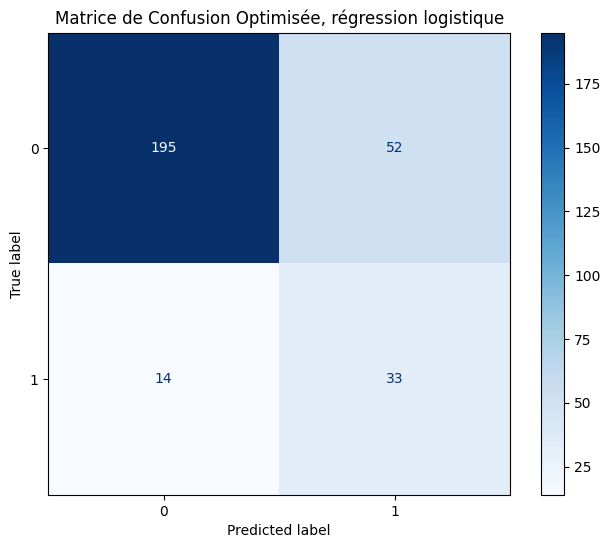

In [283]:
from sklearn.model_selection import GridSearchCV

# 1. On définit la grille pour la régression logistique
# On teste différentes forces de régularisation (C)
# On teste aussi 'l1' (Lasso) et 'l2' (Ridge) si le solver le permet
param_grid_log = {
    'model__C': [0.01, 0.1, 1, 10, 100], 
    'model__penalty': ['l2'],
    'model__solver': ['lbfgs'] # Solver standard robuste
}

# 2. GridSearch sur le pipeline linéaire
grid_log = GridSearchCV(
    pipeline_logreg, 
    param_grid_log, 
    cv=5, 
    scoring=scoring_grid_search,
    n_jobs=-1
)

print("Optimisation de la Régression Logistique en cours...")
grid_log.fit(X_train, y_train)

print(f"Meilleur score F1 (Logistique Optimisée) : {grid_log.best_score_:.4f}")
print(f"Meilleurs paramètres : {grid_log.best_params_}")

# 1. Récupération du meilleur modèle (déjà réentraîné)
best_log = grid_log.best_estimator_

# 2. Prédictions sur le jeu de test
y_pred_optimised = best_log.predict(X_test)

# 3. Rapport de Classification
print("--- Résultats du Modèle Optimisé ---")
print(classification_report(y_test, y_pred_optimised))

# 4. Affichage de la Matrice de Confusion
fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_optimised)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_log.classes_)
disp.plot(cmap='Blues', ax=ax)
ax.set_title(f"Matrice de Confusion Optimisée, régression logistique")
plt.show()

In [284]:
# 1. Définir la grille des paramètres à tester
# On teste différentes "formes" de forêt pour voir laquelle attrape le mieux les départs

param_grid = {
    'model__n_estimators': [100, 200], # Nombre d'arbres
    'model__max_depth': [5, 10, 20, None], # Profondeur max (None = illimité)
    'model__min_samples_leaf': [1, 2, 4],  # Nombre min de feuilles (évite le surapprentissage)
    'smote__k_neighbors': [3, 5, 7]  # Nombre de voisins pour SMOTE
}

# 2. Initialiser le GridSearch
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring= scoring_grid_search,  # On peut aussi mettre 'f1' si on veut garder un équilibre
    cv=5,              # 5 validations croisées
    n_jobs=-1,         # Utilise tous les cœurs du processeur
    verbose=2
)

# 3. Lancer la recherche des meilleurs paramètres
print("Recherche des meilleurs paramètres en cours...")
grid_search.fit(X_train, y_train)

# 4. Résultats
print(f"\nMeilleurs paramètres trouvés : {grid_search.best_params_}")
print(f"Meilleur score de {scoring_grid_search} validé : {grid_search.best_score_:.4f}")

# On récupère le meilleur modèle pour la suite
best_rf = grid_search.best_estimator_

Recherche des meilleurs paramètres en cours...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=100, smote__k_neighbors=3; total time=   0.5s
[CV] END model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=100, smote__k_neighbors=5; total time=   0.5s
[CV] END model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=100, smote__k_neighbors=3; total time=   0.5s
[CV] END model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=100, smote__k_neighbors=5; total time=   0.5s
[CV] END model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=100, smote__k_neighbors=3; total time=   0.5s
[CV] END model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=100, smote__k_neighbors=5; total time=   0.5s
[CV] END model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=100, smote__k_neighbors=3; total time=   0.6s
[CV] END model__max_depth=5, model__m

Recherche des meilleurs hyperparamètres (Mode Class Weight)...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Meilleurs paramètres trouvés : {'model__class_weight': 'balanced', 'model__max_depth': 20, 'model__min_samples_leaf': 6, 'model__n_estimators': 100}
Meilleur score (CV) : 0.5016
--- Résultats du Modèle Optimisé ---
              precision    recall  f1-score   support

           0       0.91      0.88      0.90       247
           1       0.46      0.53      0.50        47

    accuracy                           0.83       294
   macro avg       0.69      0.71      0.70       294
weighted avg       0.84      0.83      0.83       294



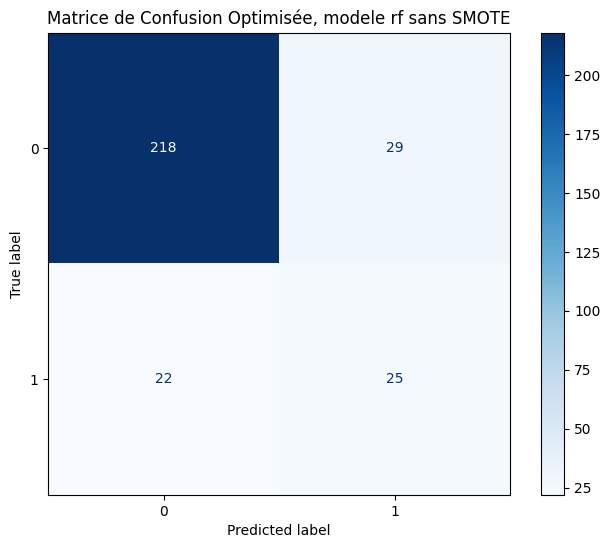

In [285]:
### Recherche d'hyperparamètres pour le modèle sans imblearn ###

# 1. Définir la grille des paramètres à tester
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [5, 10, 20, None],
    
    # Important avec class_weight : on évite 1 pour réduire l'overfitting sur les cas isolés
    'model__min_samples_leaf': [2, 4, 6],  
    
    # C'est ici qu'on teste les deux stratégies de gestion du déséquilibre
    'model__class_weight': ['balanced', 'balanced_subsample'] 
}

# 2. Initialiser le GridSearch
grid_search = GridSearchCV(
    estimator=pipeline_cw,
    param_grid=param_grid,
    
    # Choix de la métrique
    scoring=scoring_grid_search, 
    
    cv=cv_strat,       # On réutilise la otre validation croisée stratifiée définie plus tôt
    n_jobs=-1,
    verbose=1
)

# 3. Lancer la recherche
print("Recherche des meilleurs hyperparamètres (Mode Class Weight)...")
grid_search.fit(X_train, y_train)

# 4. Résultats
print(f"\nMeilleurs paramètres trouvés : {grid_search.best_params_}")
print(f"Meilleur score (CV) : {grid_search.best_score_:.4f}")

# On récupère le champion
best_rf_cw = grid_search.best_estimator_


# 2. Prédictions sur le jeu de test
y_pred_optimised = best_rf_cw.predict(X_test)

# 3. Rapport de Classification
print("--- Résultats du Modèle Optimisé ---")
print(classification_report(y_test, y_pred_optimised))

# 4. Affichage de la Matrice de Confusion
fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_optimised)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf_cw.classes_)
disp.plot(cmap='Blues', ax=ax)
ax.set_title(f"Matrice de Confusion Optimisée, modele rf sans SMOTE")
plt.show()

--- Résultats du Modèle Optimisé ---
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       247
           1       0.42      0.38      0.40        47

    accuracy                           0.82       294
   macro avg       0.65      0.64      0.65       294
weighted avg       0.81      0.82      0.81       294



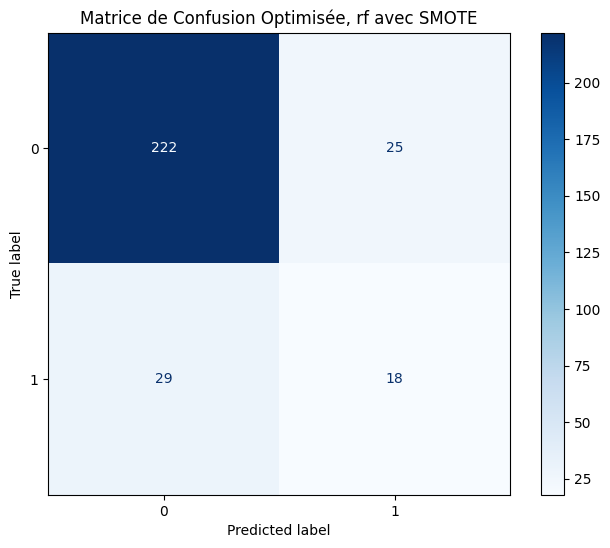

In [286]:
# 2. Prédictions sur le jeu de test
y_pred_optimised = best_rf.predict(X_test)

# 3. Rapport de Classification
print("--- Résultats du Modèle Optimisé ---")
print(classification_report(y_test, y_pred_optimised))

# 4. Affichage de la Matrice de Confusion
fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_optimised)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf.classes_)
disp.plot(cmap='Blues', ax=ax)
ax.set_title(f"Matrice de Confusion Optimisée, rf avec SMOTE")
plt.show()

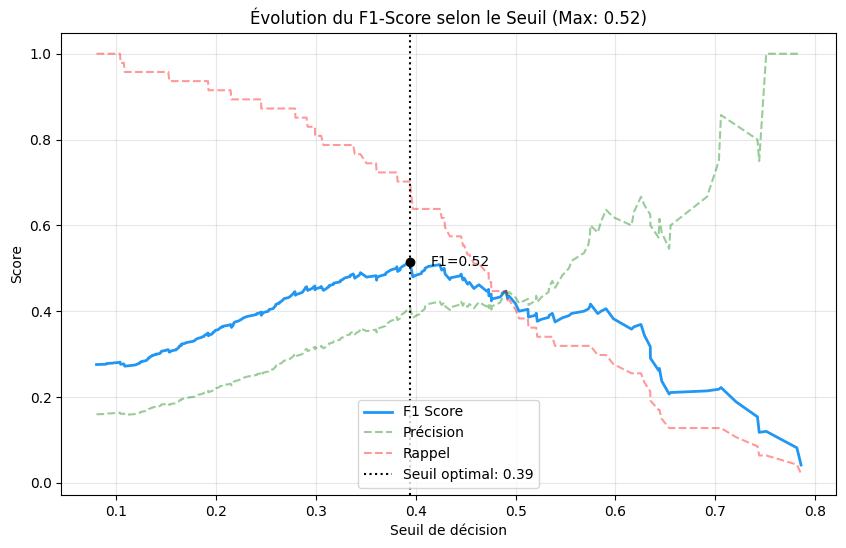

In [287]:
best_threshold = plot_f1_vs_threshold(best_rf, X_test, y_test)

In [288]:
# # Un peu mieux mais toujours pas foufou, on va essayerd'abaisser le seuil tout simplement
# # On demande les probabilités (ex: [0.8, 0.2] -> 20% de chance de partir)
# y_proba = best_rf.predict_proba(X_test)[:, 1]

# # Testons un seuil plus bas pour attraper plus de monde
# nouveau_seuil = 0.40  # Essayez de changer ce chiffre (0.35, 0.45...)
# y_pred_seuil = (y_proba >= nouveau_seuil).astype(int)

# print(f"--- Résultats avec Seuil abaissé à {nouveau_seuil*100}% ---")
# print(classification_report(y_test, y_pred_seuil))

# # Comparaison rapide des matrices
# cm_seuil = confusion_matrix(y_test, y_pred_seuil)
# print(f"Vrais départs détectés (Recall) : {cm_seuil[1,1]} / {cm_seuil[1,:].sum()}")

# # 4. Affichage de la Matrice de Confusion
# fig, ax = plt.subplots(figsize=(8, 6))
# disp = ConfusionMatrixDisplay(confusion_matrix=cm_seuil, display_labels=best_rf.classes_)
# disp.plot(cmap='Blues', ax=ax)
# ax.set_title(f"Matrice de Confusion pour la RF Optimisée")
# plt.show()

In [289]:
### recherche de seuil pour la regression logistique ###

# # On demande les probabilités (ex: [0.8, 0.2] -> 20% de chance de partir)
# y_proba = best_log.predict_proba(X_test)[:, 1]

# # Testons un seuil plus bas pour attraper plus de monde
# nouveau_seuil = 0.40  # Essayez de changer ce chiffre (0.35, 0.45...)
# y_pred_seuil = (y_proba >= nouveau_seuil).astype(int)

# print(f"--- Résultats avec Seuil abaissé à {nouveau_seuil*100}% ---")
# print(classification_report(y_test, y_pred_seuil))

# # Comparaison rapide des matrices
# cm_seuil = confusion_matrix(y_test, y_pred_seuil)
# print(f"Vrais départs détectés (Recall) : {cm_seuil[1,1]} / {cm_seuil[1,:].sum()}")

# # 4. Affichage de la Matrice de Confusion
# fig, ax = plt.subplots(figsize=(8, 6))
# disp = ConfusionMatrixDisplay(confusion_matrix=cm_seuil, display_labels=best_rf.classes_)
# disp.plot(cmap='Blues', ax=ax)
# ax.set_title(f"Matrice de Confusion Optimisée")
# plt.show()

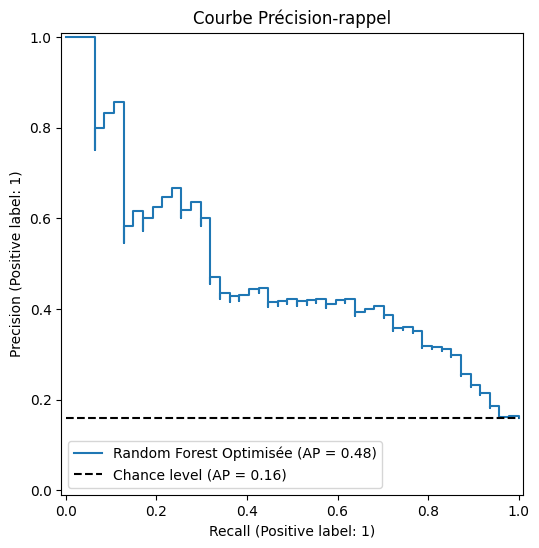

In [290]:
# Utilisation de la courbe Précision / Rappel pour déterminer le meilleur paramède de seuil
# mieux que ROC car nos classes sont déséquilibrées

from sklearn.metrics import PrecisionRecallDisplay

# On utilise le best_estimator_ trouvé par le GridSearch
fig, ax = plt.subplots(figsize=(8, 6))

disp = PrecisionRecallDisplay.from_estimator(
    best_rf, 
    X_test, 
    y_test, 
    name="Random Forest Optimisée",
    plot_chance_level=True,  # Affiche la ligne de hasard pour comparer
    ax=ax
)

ax.set_title("Courbe Précision-rappel")
plt.show()

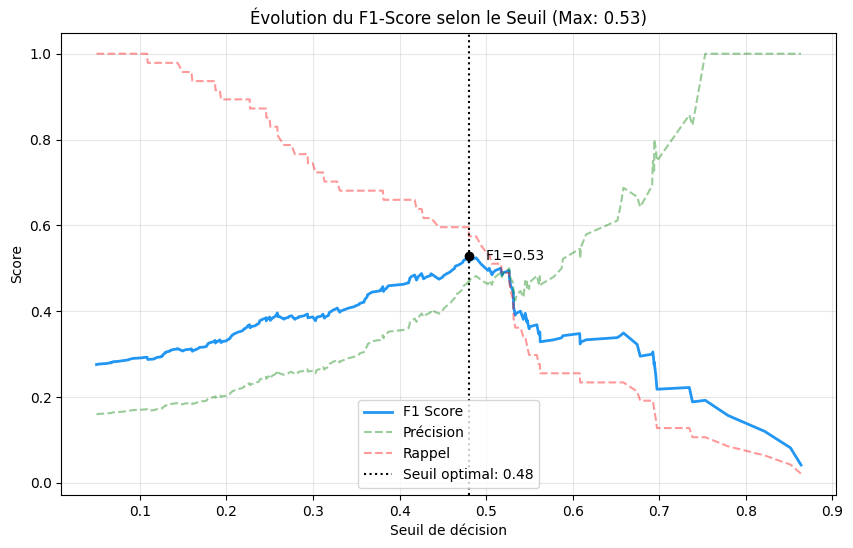

In [291]:
best_threshold = plot_f1_vs_threshold(best_rf_cw, X_test, y_test)

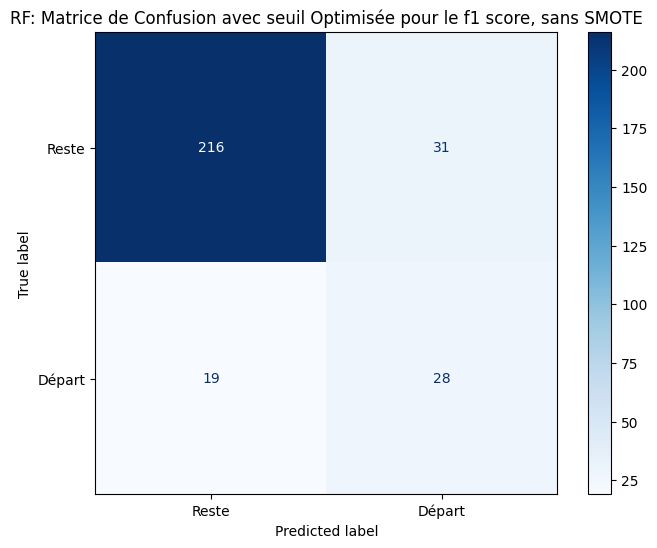

In [292]:

#4. Appliquons ce seuil pour voir le résultat final
y_probas = best_rf_cw.predict_proba(X_test)[:, 1]
y_pred_optimal = (y_probas >= best_threshold).astype(int)


cm = confusion_matrix(y_test, y_pred_optimal)

# 4. Affichage de la Matrice de Confusion
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Reste", "Départ"])
disp.plot(cmap='Blues', ax=ax)
ax.set_title(f"RF: Matrice de Confusion avec seuil Optimisée pour le f1 score, sans SMOTE")
plt.show()

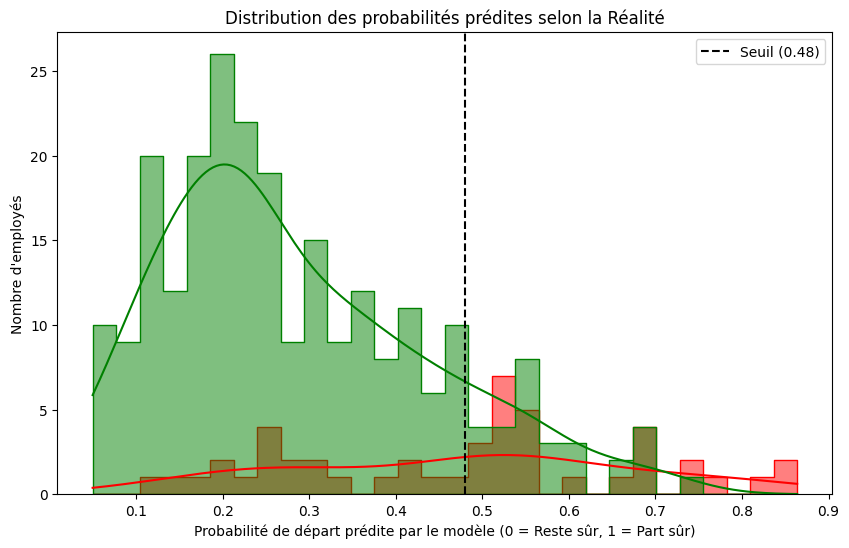

In [293]:
# 1. On crée un petit DataFrame temporaire pour faciliter le traçage
df_visu = pd.DataFrame({
    'Probabilité_Départ': y_probas,
    'Réalité': y_test
})

# On renomme pour que ce soit joli sur le graphe
df_visu['Réalité'] = df_visu['Réalité'].map({0: 'Est Resté', 1: 'Est Parti'})

# 2. Le graphique
plt.figure(figsize=(10, 6))

# Histogramme superposé
sns.histplot(
    data=df_visu, 
    x='Probabilité_Départ', 
    hue='Réalité', 
    kde=True,              # Ajoute la courbe de densité
    bins=30,               # Nombre de barres
    palette={'Est Resté': 'green', 'Est Parti': 'red'},
    alpha=0.5,             # Transparence pour voir les chevauchements
    element="step"         # Style visuel
)

# On ajoute votre ligne de seuil optimal pour voir la limite
plt.axvline(best_threshold, color='black', linestyle='--', label=f'Seuil ({best_threshold:.2f})')

plt.title("Distribution des probabilités prédites selon la Réalité")
plt.xlabel("Probabilité de départ prédite par le modèle (0 = Reste sûr, 1 = Part sûr)")
plt.ylabel("Nombre d'employés")
plt.legend()
plt.show()

--- Le Seuil Optimal Mathématique ---
Meilleur Seuil (Threshold) : 0.3945
F1-Score associé : 0.5156
Recall associé   : 0.7021
Precision associée: 0.4074


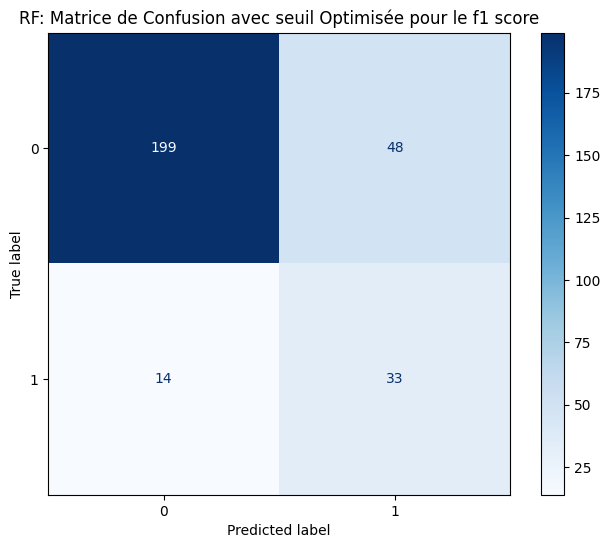

In [294]:
import numpy as np
from sklearn.metrics import precision_recall_curve

# 1. On récupère les points de la courbe
y_probas = best_rf.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probas)

# 2. On calcule le F1-Score pour CHAQUE seuil possible
# F1 = 2 * (Precision * Recall) / (Precision + Recall)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

# 3. On trouve l'index du meilleur F1
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
best_f1 = f1_scores[best_index]

print(f"--- Le Seuil Optimal Mathématique ---")
print(f"Meilleur Seuil (Threshold) : {best_threshold:.4f}")
print(f"F1-Score associé : {best_f1:.4f}")
print(f"Recall associé   : {recalls[best_index]:.4f}")
print(f"Precision associée: {precisions[best_index]:.4f}")

# 4. Appliquons ce seuil pour voir le résultat final
y_pred_optimal = (y_probas >= best_threshold).astype(int)


cm = confusion_matrix(y_test, y_pred_optimal)

# 4. Affichage de la Matrice de Confusion
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf.classes_)
disp.plot(cmap='Blues', ax=ax)
ax.set_title(f"RF: Matrice de Confusion avec seuil Optimisée pour le f1 score")
plt.show()

--- Le Seuil Optimal Mathématique ---
Meilleur Seuil (Threshold) : 0.7329
F1-Score associé : 0.5542
Recall associé   : 0.4894
Precision associée: 0.6389


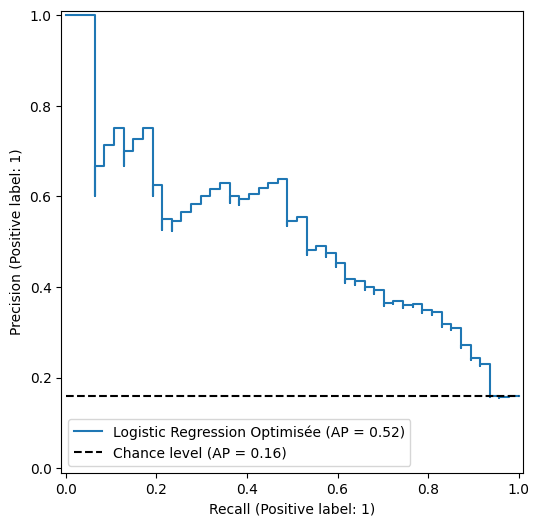

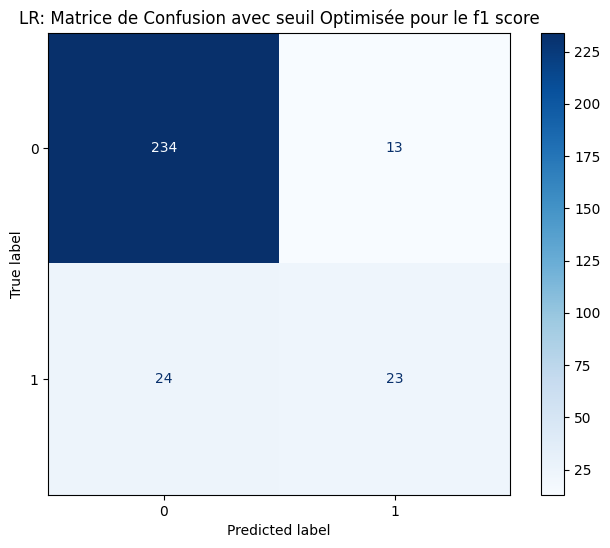

In [295]:
## pareil pour la régression logistique ##

# Utilisation de la courbe Précision / Rappel pour déterminer le meilleur paramède de seuil
# mieux que ROC car nos classes sont déséquilibrées

from sklearn.metrics import PrecisionRecallDisplay

# On utilise le best_estimator_ trouvé par le GridSearch
fig, ax = plt.subplots(figsize=(8, 6))

disp = PrecisionRecallDisplay.from_estimator(
    best_log, 
    X_test, 
    y_test, 
    name="Logistic Regression Optimisée",
    plot_chance_level=True,  # Affiche la ligne de hasard pour comparer
    ax=ax
)

# 1. On récupère les points de la courbe
y_probas = best_log.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probas)

# 2. On calcule le F1-Score pour CHAQUE seuil possible
# F1 = 2 * (Precision * Recall) / (Precision + Recall)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

# 3. On trouve l'index du meilleur F1
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
best_f1 = f1_scores[best_index]

print(f"--- Le Seuil Optimal Mathématique ---")
print(f"Meilleur Seuil (Threshold) : {best_threshold:.4f}")
print(f"F1-Score associé : {best_f1:.4f}")
print(f"Recall associé   : {recalls[best_index]:.4f}")
print(f"Precision associée: {precisions[best_index]:.4f}")

# 4. Appliquons ce seuil pour voir le résultat final
y_pred_optimal = (y_probas >= best_threshold).astype(int)


cm = confusion_matrix(y_test, y_pred_optimal)

# 4. Affichage de la Matrice de Confusion
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_log.classes_)
disp.plot(cmap='Blues', ax=ax)
ax.set_title(f"LR: Matrice de Confusion avec seuil Optimisée pour le f1 score")
plt.show()

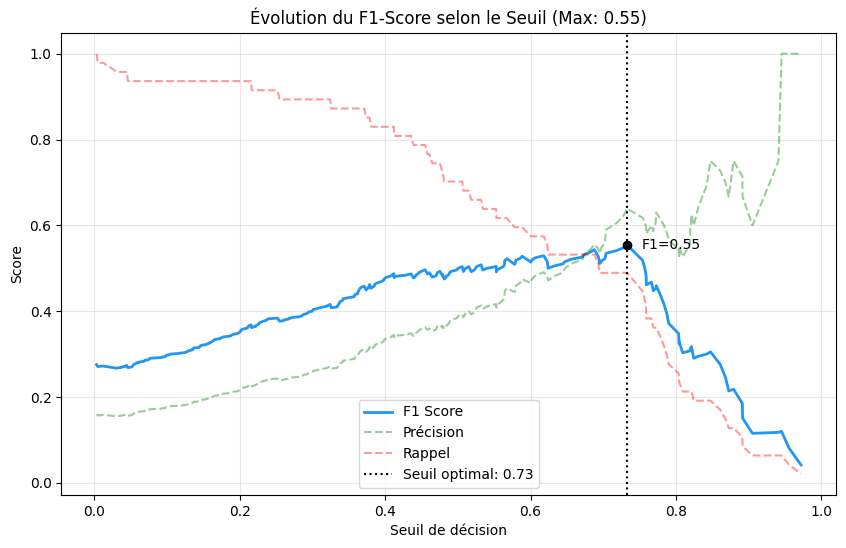

In [296]:
best_threshold = plot_f1_vs_threshold(best_log, X_test, y_test)

/tmp/ipykernel_4072/718183934.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


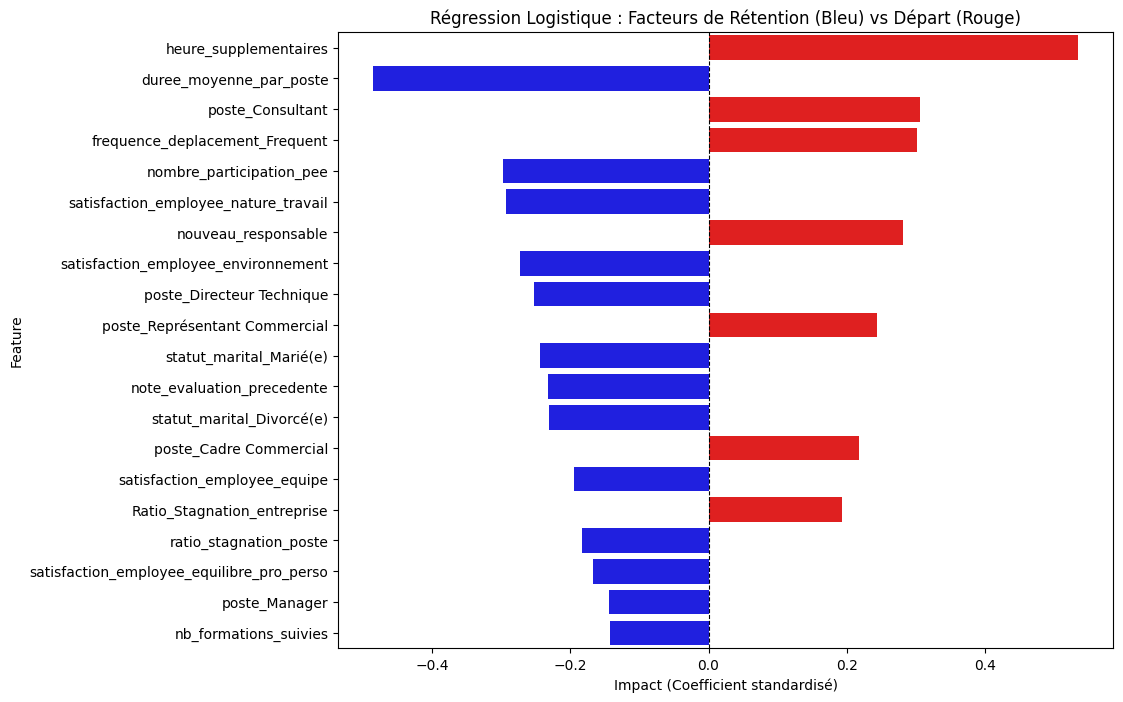

In [297]:
## Visualisation des coefficients de la régression logistique ###
#X_test_copie = X_test.copy()
# 1. Récupération du modèle et du préprocesseur depuis le pipeline logistique
# Remplacez 'pipeline_lineaire' par le nom de votre variable (ex: grid_log.best_estimator_)

model_log = best_log.named_steps['model']
preprocessor = best_log.named_steps['encoder'] # Ou 'preprocessor' selon votre nommage

# 2. Récupération des noms de colonnes et des coefficients
# On récupère les noms après encodage OneHot
feature_names = preprocessor.get_feature_names_out()
# On récupère les coefficients (c'est une liste de liste, on prend la première)
coefficients = model_log.coef_[0]

# 3. Création d'un DataFrame pour le tri
df_coeffs = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# On trie par magnitude (valeur absolue) pour voir les plus impactants en haut
df_coeffs['Abs_Coeff'] = df_coeffs['Coefficient'].abs()
df_coeffs = df_coeffs.sort_values(by='Abs_Coeff', ascending=False).head(20) # Top 20

# 4. Le Graphique "Tornade"
plt.figure(figsize=(10, 8))
colors = ['red' if c > 0 else 'blue' for c in df_coeffs['Coefficient']]

sns.barplot(
    data=df_coeffs,
    x='Coefficient',
    y='Feature',
    palette=colors
)

plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.title("Régression Logistique : Facteurs de Rétention (Bleu) vs Départ (Rouge)")
plt.xlabel("Impact (Coefficient standardisé)")
plt.show()

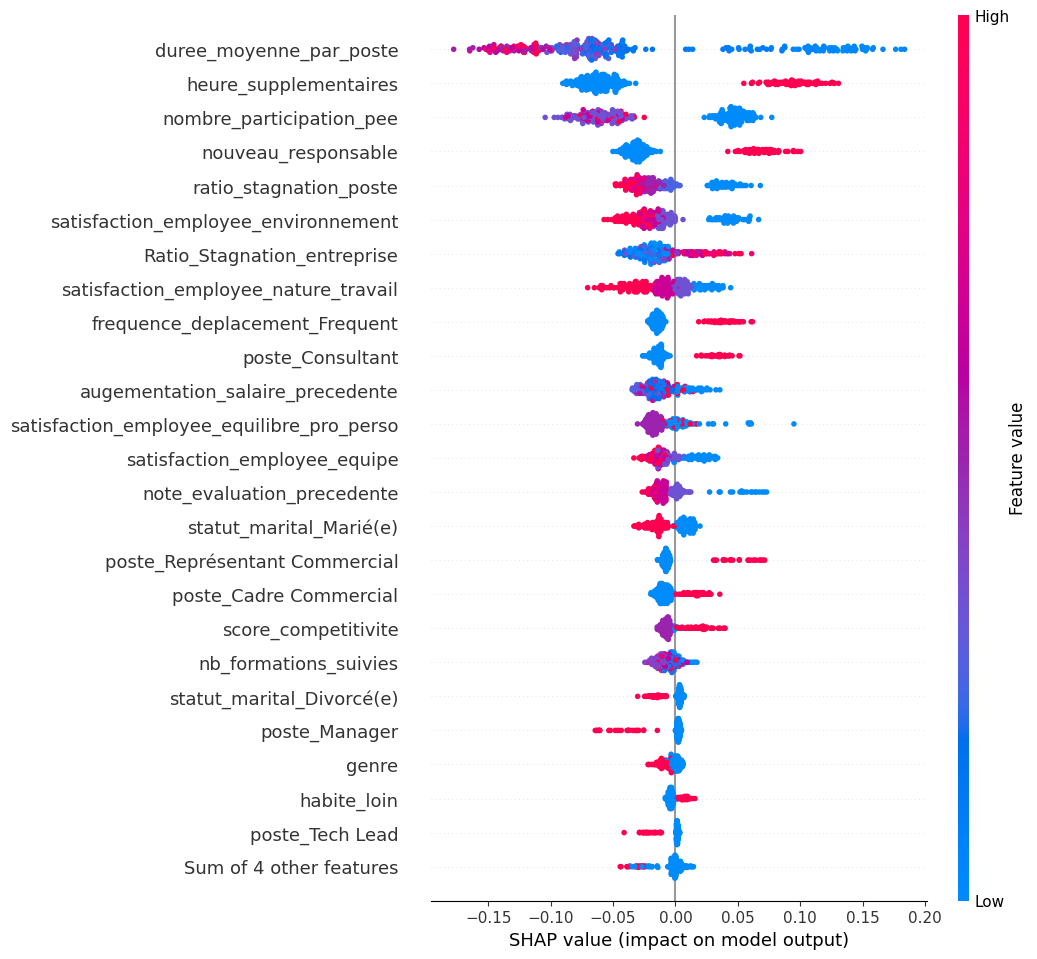

In [298]:
### Shapley values ###
import shap

#  On récupère juste le modèle (la dernière étape nommée 'model')
rf_model_extracted = best_rf_cw.named_steps['model']

# 1. On récupère les étapes de préparation par leur nom
step_fe = best_rf_cw.named_steps['salary_ref']
step_enc = best_rf_cw.named_steps['encoder']
# On applique le pré-traitement (Feature Eng. + Encodage) à X_test
# Le modèle a besoin de ces données transformées, pas des données brutes.
X_test_transformed = step_fe.transform(X_test)
X_test_transformed = step_enc.transform(X_test_transformed)
# On donne le modèle extrait à l'explainer
explainer = shap.TreeExplainer(rf_model_extracted)

# On donne les données transformées pour le calcul
explanation = explainer(X_test_transformed)

# Calcule des shap values
# rappel, classe 0 = reste, classe 1 = part
classe_a_interpreter = 1

# Petit hack pour remettre les noms de colonnes corrects sur le graphique
# (Car le transformer perd parfois les noms)
feature_names = step_enc.get_feature_names_out()
explanation.feature_names = feature_names

shap.plots.beeswarm(explanation[:, :, classe_a_interpreter], max_display=25)

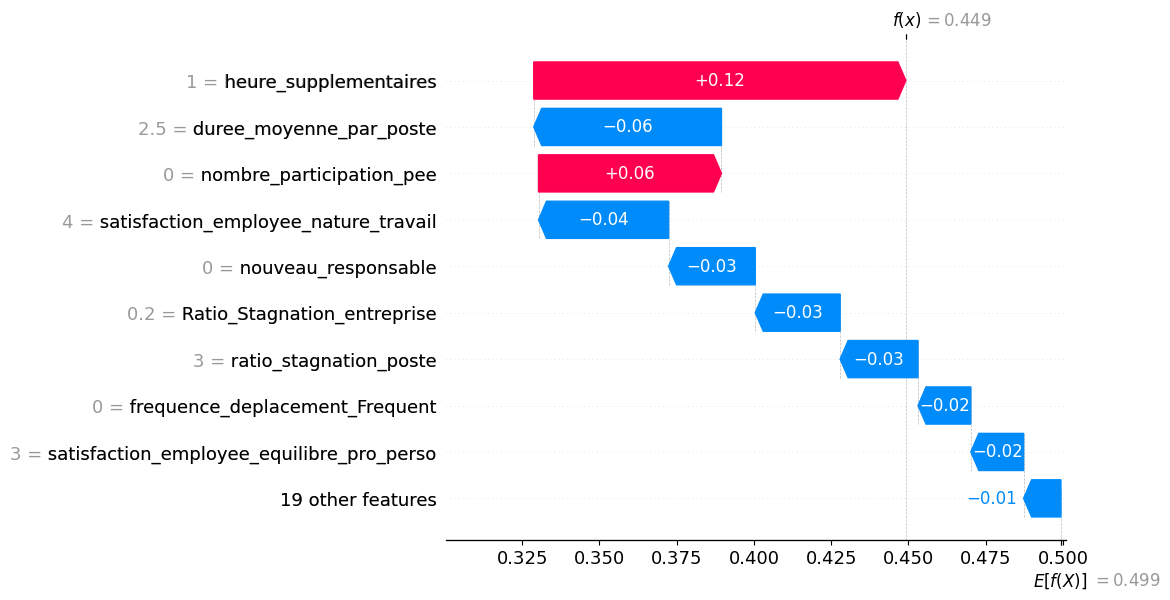

Vraie valeur pour cet employé : Est Resté


In [299]:
# shap.initjs() # Nécessaire pour les notebooks interactifs
# # Visualiser la nème prédiction du jeu de test, valeurs locales
# n = 0
# shap.force_plot(explainer.expected_value, shap_values[n,:], X_test.iloc[n,:])

index_employee = 25
shap.plots.waterfall(explanation[index_employee, :, classe_a_interpreter])
vraie_valeur = y_test.iloc[index_employee]
print(f"Vraie valeur pour cet employé : {'Est Parti' if vraie_valeur == 1 else 'Est Resté'}")

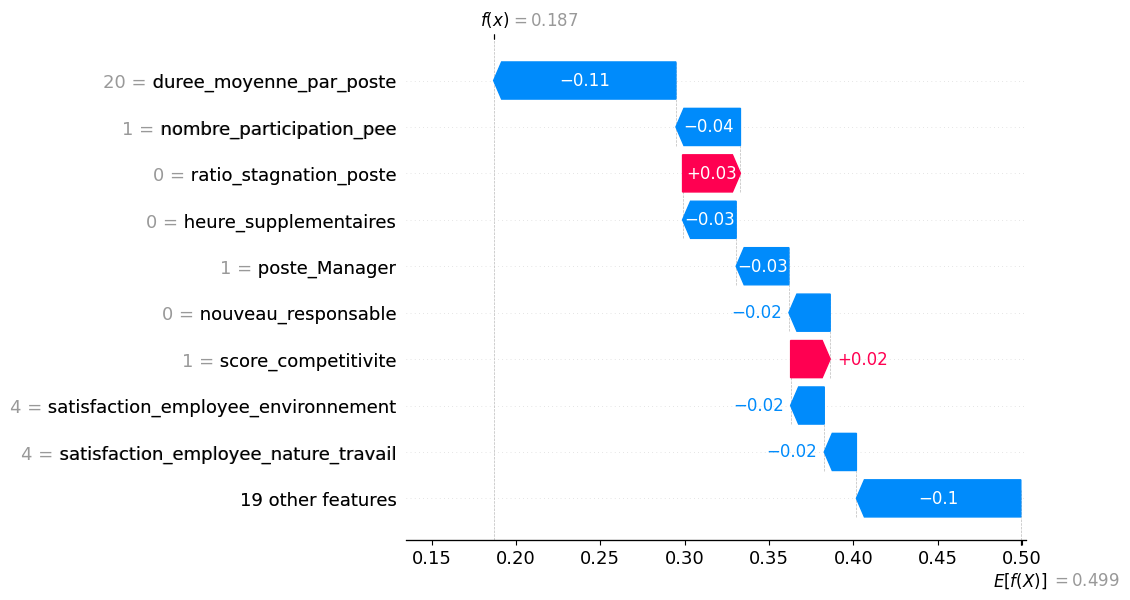

Vraie valeur pour cet employé : Est Parti


In [300]:
index_employee = 82
shap.plots.waterfall(explanation[index_employee, :, classe_a_interpreter])
vraie_valeur = y_test.iloc[index_employee]
print(f"Vraie valeur pour cet employé : {'Est Parti' if vraie_valeur == 1 else 'Est Resté'}")

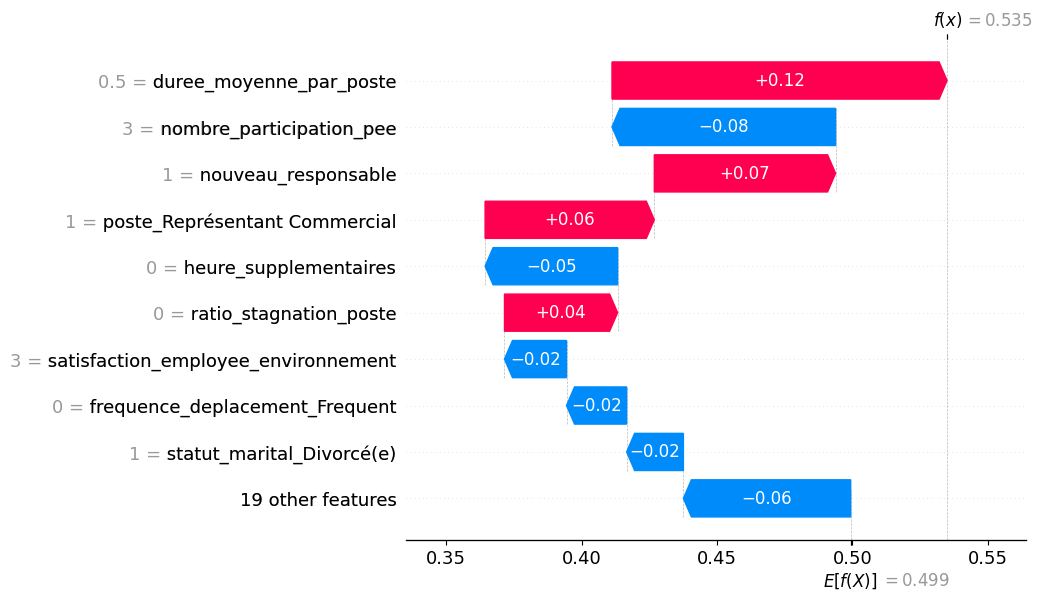

Vraie valeur pour cet employé : Est Resté


In [301]:
index_employee = 69
shap.plots.waterfall(explanation[index_employee, :, classe_a_interpreter])
vraie_valeur = y_test.iloc[index_employee]
print(f"Vraie valeur pour cet employé : {'Est Parti' if vraie_valeur == 1 else 'Est Resté'}")

/tmp/ipykernel_4072/1930290226.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(


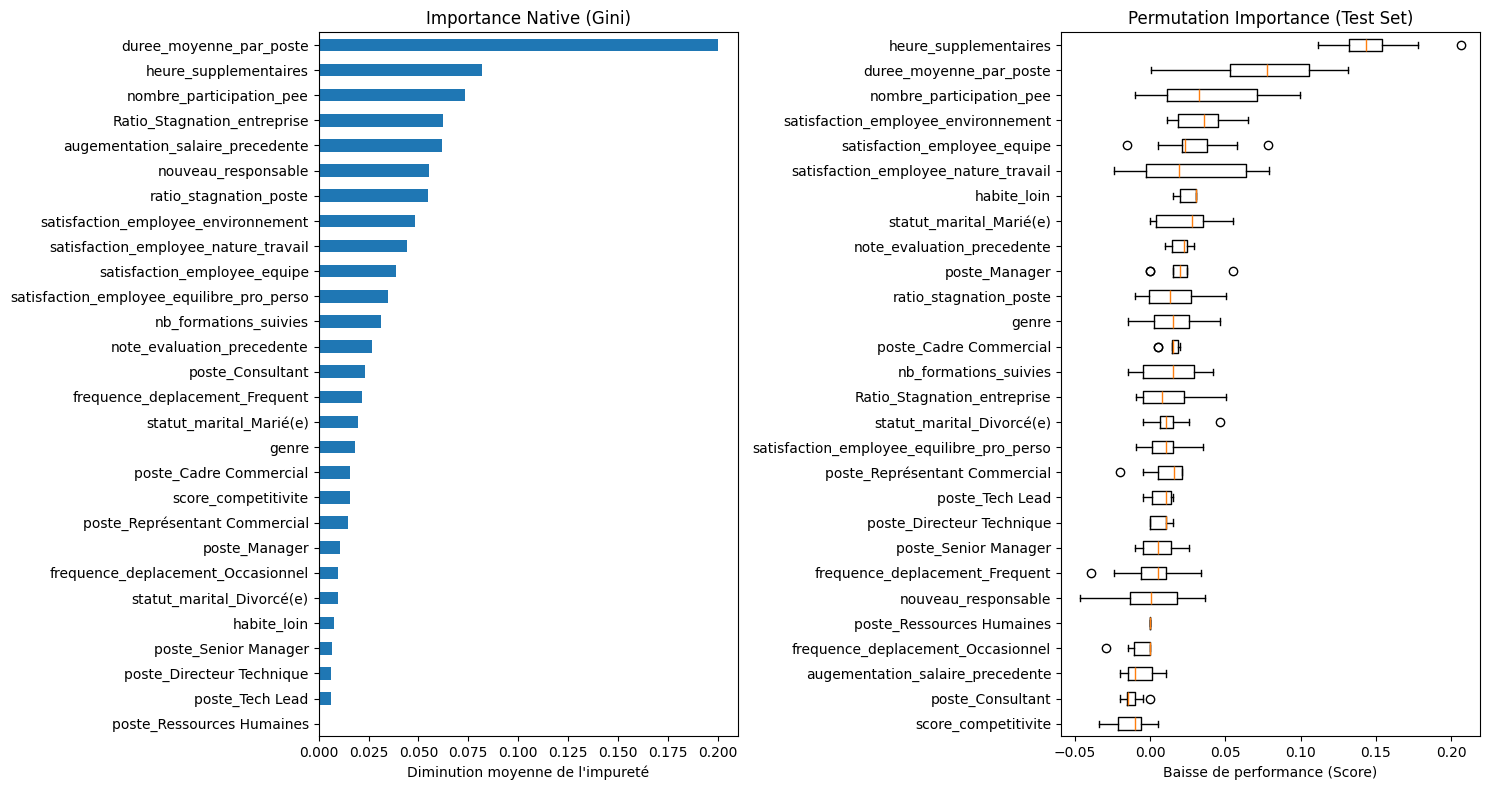

In [302]:
from sklearn.inspection import permutation_importance

# 1. Importance Native (MDI - Mean Decrease in Impurity)
mdi_importances = pd.Series(
    rf_model_extracted.feature_importances_, 
    index=feature_names
).sort_values(ascending=True)


# --- ÉTAPE 3 : Permutation Importance ---
# On calcule sur le modèle extrait et les données transformées
perm_importance = permutation_importance(
    rf_model_extracted, 
    X_test_transformed,
    y_test,
    scoring=scoring_method,  
    n_repeats=10, 
    random_state=42, 
    n_jobs=-1
)
sorted_idx = perm_importance.importances_mean.argsort()


# --- ÉTAPE 4 : Affichage Comparatif ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8)) 

# Graphique Importance Native
mdi_importances.plot(kind='barh', ax=ax1, title="Importance Native (Gini)")
ax1.set_xlabel("Diminution moyenne de l'impureté")

# Graphique Permutation
ax2.boxplot(
    perm_importance.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names)[sorted_idx] # On utilise les noms corrects
)
ax2.set_title("Permutation Importance (Test Set)")
ax2.set_xlabel("Baisse de performance (Score)")

plt.tight_layout()
plt.show()